## Importación de las librerías

In [40]:
import utils
import pickle
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

## Conjuntos de entrenamiento y test y CV controller

In [2]:
X_train, X_test, y_train, y_test = utils.get_train_test_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7776, 12) (1022, 12) (7776,) (1022,)


In [3]:
cv = utils.get_stratified_shuffle_cv()
print(cv)

StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8)


## Carga del mejor modelo de regresión logística

Este será el modelo que se empleará para realizar el **bagging**

In [4]:
log_reg_model = pickle.load(open('/kaggle/input/logistic-regression-model/logistic_regression_model.sav', 'rb'))
log_reg_model

LogisticRegression(C=0.5, random_state=99, solver='saga')

## Búsqueda del parámetro max_samples del bagging

In [7]:
param_grid = {
    'n_estimators': list(range(50,501,50)),
    'max_samples': list(np.arange(0.1,1.01,0.1))
}

grid_search_cv = GridSearchCV(
    BaggingClassifier(
        base_estimator=LogisticRegression(C=log_reg_model.C, solver=log_reg_model.solver, random_state=log_reg_model.random_state),
        random_state=99
    ),
    param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=0, n_jobs=-1
)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=BaggingClassifier(base_estimator=LogisticRegression(C=0.5,
                                                                           random_state=99,
                                                                           solver='saga'),
                                         random_state=99),
             n_jobs=-1,
             param_grid={'max_samples': [0.1, 0.2, 0.30000000000000004, 0.4,
                                         0.5, 0.6, 0.7000000000000001, 0.8, 0.9,
                                         1.0],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500]},
             scoring='roc_auc')

Escogemos como **max_samples** 0.3 no hay diferencia apenas, a partir de alli

<AxesSubplot:xlabel='estimators', ylabel='mean_test_score'>

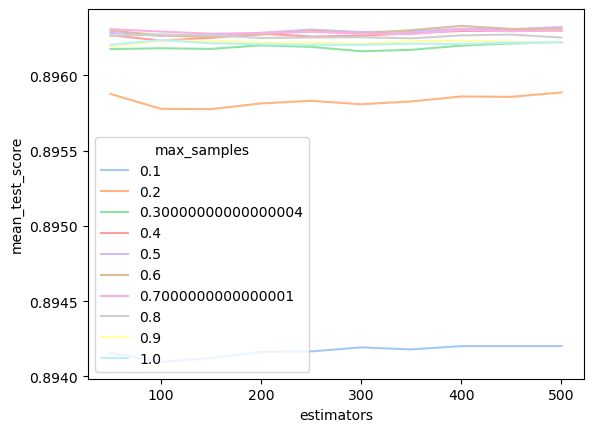

In [8]:
estimators_list = list(grid_search_cv.cv_results_['param_n_estimators'].data)
max_samples_list = list(grid_search_cv.cv_results_['param_max_samples'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
bagging_df = pd.DataFrame(list(zip(estimators_list, max_samples_list, mean_test_score_list)), columns=['estimators', 'max_samples', 'mean_test_score'])
sns.lineplot(data=bagging_df, x="estimators", y="mean_test_score", hue='max_samples', legend="full", palette="pastel")

## Búsqueda del modelo de bagging

In [9]:
param_grid = {
    'n_estimators': list(range(10,300,10))
}

grid_search_cv = GridSearchCV(
    BaggingClassifier(
        base_estimator=LogisticRegression(C=log_reg_model.C, solver=log_reg_model.solver, random_state=log_reg_model.random_state),
        max_samples = 0.3, random_state=99
    ),
    param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=0, n_jobs=-1
)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=BaggingClassifier(base_estimator=LogisticRegression(C=0.5,
                                                                           random_state=99,
                                                                           solver='saga'),
                                         max_samples=0.3, random_state=99),
             n_jobs=-1,
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290]},
             scoring='roc_auc')

Decidimos que el número de árboles a usar será: **10** ya que la mejora desde 10 a 290 es insignificativa, se queda en 89.6%

<AxesSubplot:xlabel='estimators', ylabel='mean_test_score'>

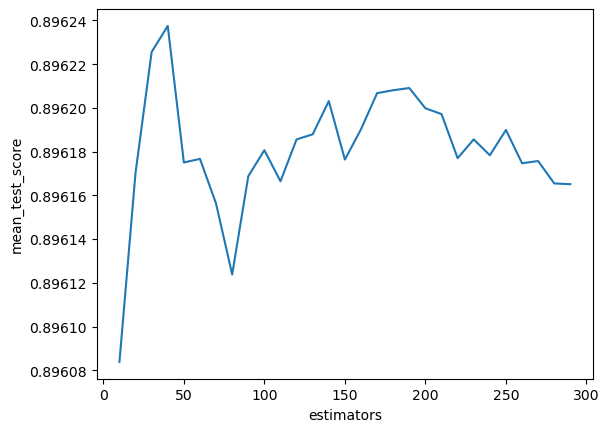

In [10]:
estimators_list = list(grid_search_cv.cv_results_['param_n_estimators'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
bagging_df = pd.DataFrame(list(zip(estimators_list, mean_test_score_list)), columns=['estimators', 'mean_test_score'])
bagging_df['mean_test_score_shift'] = bagging_df['mean_test_score'].shift().fillna(0)
bagging_df['diff'] = (bagging_df['mean_test_score'] - bagging_df['mean_test_score_shift'])
sns.lineplot(data=bagging_df, x="estimators", y="mean_test_score")

In [11]:
bagging_df

,estimators,mean_test_score,mean_test_score_shift,diff
0,10,0.896084,0.000000,8.960838e-01
1,20,0.896170,0.896084,8.657093e-05
2,30,0.896226,0.896170,5.518071e-05
3,40,0.896237,0.896226,1.189524e-05
4,50,0.896175,0.896237,-6.245002e-05
5,60,0.896177,0.896175,1.652117e-06
6,70,0.896156,0.896177,-2.048625e-05
7,80,0.896124,0.896156,-3.238149e-05
8,90,0.896169,0.896124,4.493758e-05
9,100,0.896181,0.896169,1.189524e-05


**Modelo de bagging con regresión logística**

Confusion matrix, without normalization
[[739 233]
 [ 14  36]]


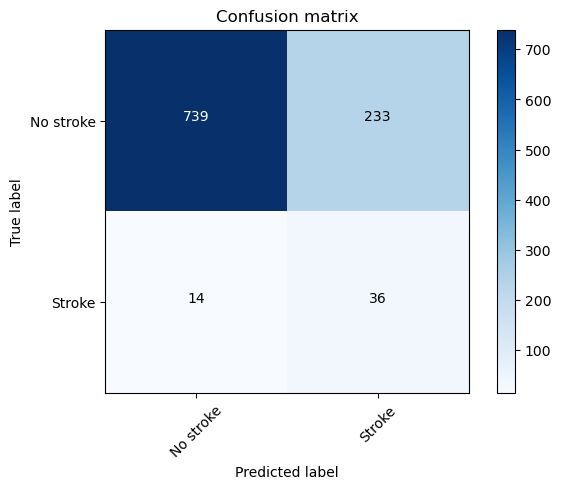

In [31]:
bagging_log_reg_model = BaggingClassifier(
    base_estimator=LogisticRegression(C=log_reg_model.C, solver=log_reg_model.solver, random_state=log_reg_model.random_state),
    n_estimators=10, max_samples=0.3, random_state=99
)

bagging_log_reg_model.fit(X_train, y_train)
y_pred = bagging_log_reg_model.predict(X_test)

cm = utils.get_confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm=cm, classes=['No stroke', 'Stroke'])

              precision    recall  f1-score   support

           0       0.98      0.76      0.86       972
           1       0.13      0.72      0.23        50

    accuracy                           0.76      1022
   macro avg       0.56      0.74      0.54      1022
weighted avg       0.94      0.76      0.83      1022



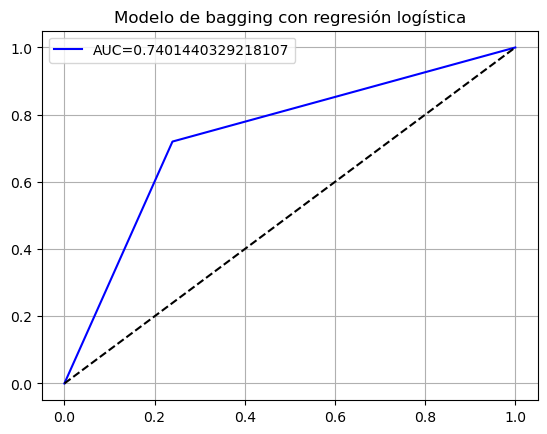

In [32]:
utils.print_metrics(y_test, y_pred, "Modelo de bagging con regresión logística")

## Importancia de las variables

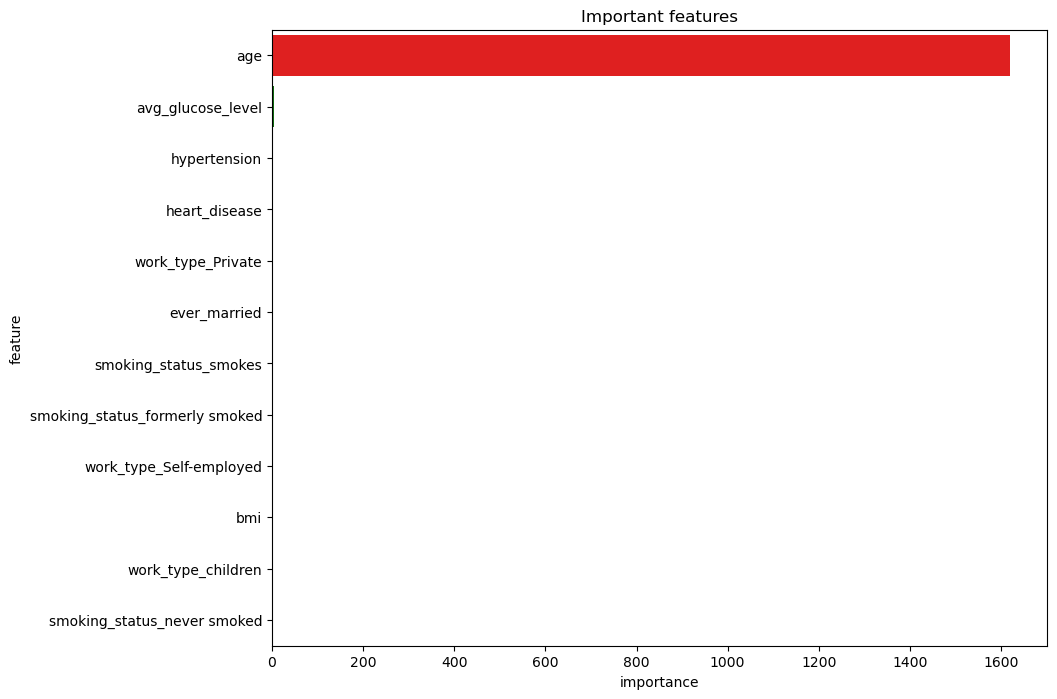

In [48]:
feature_importances = np.mean([
   pow(math.e, log_reg.coef_[0]) for log_reg in bagging_log_reg_model.estimators_
], axis=0)
utils.plot_tree_feature_importance(bagging_log_reg_model.feature_names_in_, feature_importances)

**Guardamos el modelo para la comparativa final**

In [49]:
pickle.dump(bagging_log_reg_model, open("bagging_log_reg_model.sav", 'wb'))